In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt

from pathlib import Path
from dataUtilities import filterData
from forceClass import Forces

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b, c):
        return a + (b * xData) + (c * xData**2)

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [25]:
data_location = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/gridInd_Ebrahim_constant_airfoil'

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
solver_paths = pio.get_files(data_location, 'log.solver')
solver_paths.sort()

tmp = []

constantDict = {'parentCase':[], 'specificCase':[], 'totalTime':[]}

for solverFile in solver_paths:
    constantDict['parentCase'].append(solverFile.parts[-4])
    constantDict['specificCase'].append(solverFile.parts[-3])
    with open(solverFile, 'r') as f:
        for line in f:
            if 'ExecutionTime' in line:
                tmp.append(line.split()[2])

    constantDict['totalTime'].append(tmp[-1]) 

cycles = 2.0
total_cycles = 3.0

forces = [Forces(filepath, cycles, total_cycles, True, True) for filepath in force_paths]

(-3000.0, 3000.0)

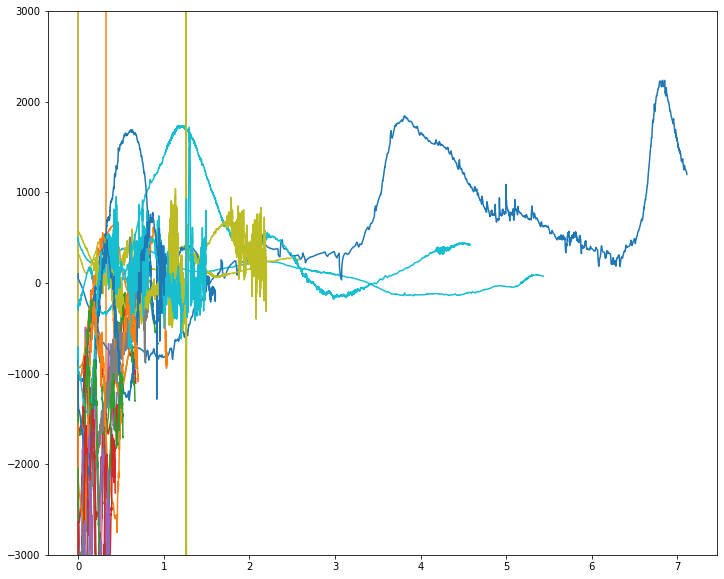

In [26]:
density = 998.2
fudgeFactor = 1.0
alpha_max = [5, 10, 15, 20, 25, 30]
average_fx = []
case = []

for force in forces:
    average_fx.append(force.averageFilteredForces['total']['x']/density)
    case.append(force.specific_case)

fig1, ax1 = plt.subplots(figsize=(12,10))
for force in forces:
    ax1.plot(force.filteredForces['time'], force.filteredForces['total']['x'], label=force.specific_case)

#ax2 = plt.axes([0, 0, 1, 1])
#ip = InsetPosition(ax1, [0.2,0.4,0.55,0.55])
#ax2.set_axes_locator(ip)
#mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

#ax1.legend()
ax1.set_ylim([-3000, 3000])

(0.5, -40.0)

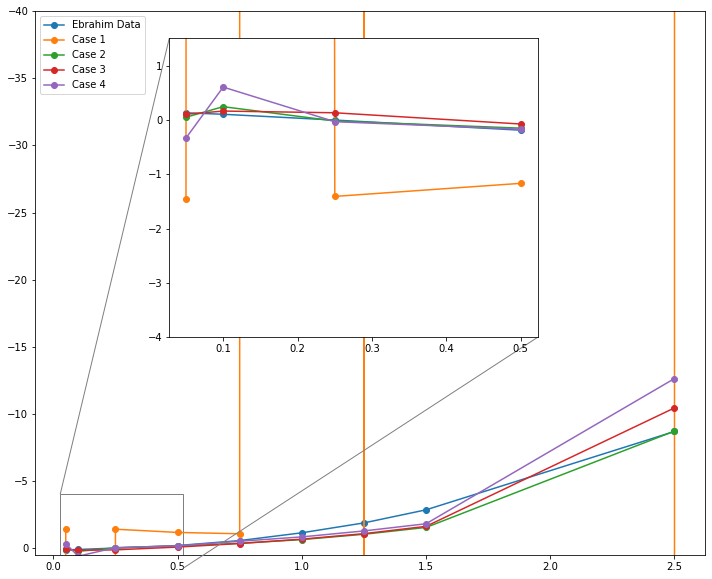

In [31]:
case1 = []
case2 = []
case3 = []
case4 = []
number_cases = 9
density = 998.2
fudgeFactor = 0.4

e_force = np.array([0.1307, 0.1039596, -0.0026195355, -0.188966, -0.559039, -1.139087, -1.8766147, -2.850414246, -8.68766])
e_st = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2.5])

for i in range(number_cases):
    case1.append(forces[i].averageFilteredForces['total']['x']/density)
    case2.append(forces[i+9].averageFilteredForces['total']['x']/density)
    case3.append(forces[i+18].averageFilteredForces['total']['x']/density)
    case4.append(forces[i+27].averageFilteredForces['total']['x']/density)

case1 = np.asarray(case1)
case1_fit = fit_data(case1, e_st)
case2 = np.asarray(case2)
case2_fit = fit_data(case2, e_st)
case3 = np.asarray(case3)
case3_fit = fit_data(case3, e_st)
case4 = np.asarray(case4)
case4_fit = fit_data(case4, e_st)

e_fit = fit_data(e_force, e_st)

fig1, ax1 = plt.subplots(figsize=(12,10))
ax1.plot(e_st, e_force, 'o-', label='Ebrahim Data')
ax1.plot(e_st, case1*fudgeFactor, 'o-', label='Case 1')
ax1.plot(e_st, case2*fudgeFactor, 'o-', label='Case 2')
ax1.plot(e_st, case3*fudgeFactor, 'o-', label='Case 3')
ax1.plot(e_st, case4*fudgeFactor, 'o-', label='Case 4')

ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax1, [0.2,0.4,0.55,0.55])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

startIndex = 0
endIndex = 4

ax2.plot(e_st[startIndex:endIndex], e_force[startIndex:endIndex], 'o-', label='Ebrahim Data')
ax2.plot(e_st[startIndex:endIndex], case1[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 1')
ax2.plot(e_st[startIndex:endIndex], case2[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 2')
ax2.plot(e_st[startIndex:endIndex], case3[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 3')
ax2.plot(e_st[startIndex:endIndex], case4[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 4')
ax2.set_ylim([-4, 1.5])

ax1.legend()
ax1.set_ylim([0.5, -40])

In [32]:
error_case1 = np.sqrt(np.sum((case1*fudgeFactor-e_force)**2)/len(e_force))
error_case2 = np.sqrt(np.sum((case2*fudgeFactor-e_force)**2)/len(e_force))
error_case3 = np.sqrt(np.sum((case3*fudgeFactor-e_force)**2)/len(e_force))
error_case4 = np.sqrt(np.sum((case4*fudgeFactor-e_force)**2)/len(e_force))

e_zero = power_law(0, *e_fit[0])
case1_zero = power_law(0, *case1_fit[0])
case2_zero = power_law(0, *case2_fit[0])
case3_zero = power_law(0, *case3_fit[0])
case4_zero = power_law(0, *case3_fit[0])

print(error_case1, error_case2, error_case3, error_case4)
print(e_zero, case1_zero, case2_zero, case3_zero, case4_zero)

2.3115119538533927e+36 0.5540007472183915 0.7853630002860151 1.3963538266706905
0.2711804756151446 0.7723517633558287 0.2948935830176699 0.33066140079753126 0.33066140079753126


In [9]:
data_location = r'/media/mco143/2TB/Archived_OpenFOAM_Simulations/gridInd_Ebrahim/gridInd_Ebrahim_constant'

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()

solver_paths = pio.get_files(data_location, 'log.solver')
solver_paths.sort()

tmp = []

gratingDict = {'parentCase':[], 'specificCase':[], 'totalTime':[]}

for solverFile in solver_paths:
    gratingDict['parentCase'].append(solverFile.parts[-4])
    gratingDict['specificCase'].append(solverFile.parts[-3])
    with open(solverFile, 'r') as f:
        for line in f:
            if 'ExecutionTime' in line:
                tmp.append(line.split()[2])

    gratingDict['totalTime'].append(tmp[-1])

forces = [Forces(filepath, 2.0, 3.0, True, True) for filepath in force_paths]

(0.5, -40.0)

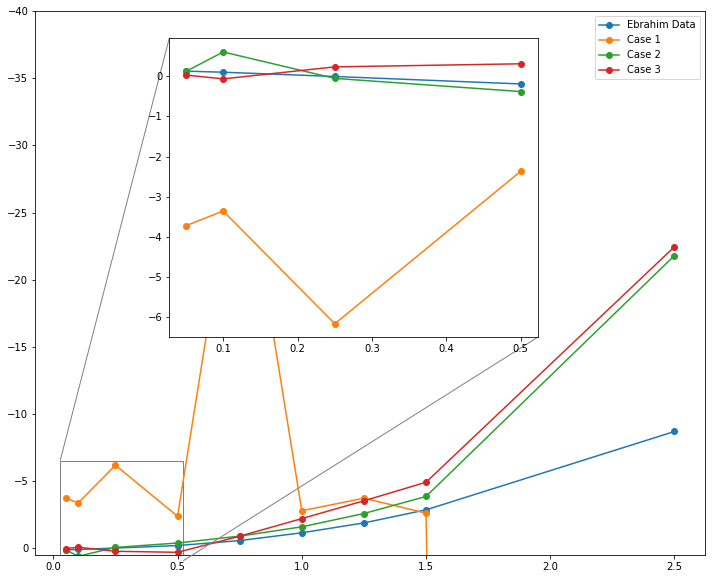

In [10]:
case1 = []
case2 = []
case3 = []
number_cases = 9
density = 998.2
fudgeFactor = 1

e_force = np.array([0.1307, 0.1039596, -0.0026195355, -0.188966, -0.559039, -1.139087, -1.8766147, -2.850414246, -8.68766])
e_st = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2.5])

for i in range(number_cases):
    case1.append(forces[i].averageFilteredForces['total']['x']/density)
    case2.append(forces[i+9].averageFilteredForces['total']['x']/density)
    case3.append(forces[i+18].averageFilteredForces['total']['x']/density)

case1 = np.asarray(case1)
case1_fit = fit_data(case1, e_st)
case2 = np.asarray(case2)
case2_fit = fit_data(case2, e_st)
case3 = np.asarray(case3)
case3_fit = fit_data(case3, e_st)

e_fit = fit_data(e_force, e_st)

fig2, ax2 = plt.subplots(figsize=(12,10))
ax2.plot(e_st, e_force, 'o-', label='Ebrahim Data')
ax2.plot(e_st, case1*fudgeFactor, 'o-', label='Case 1')
ax2.plot(e_st, case2*fudgeFactor, 'o-', label='Case 2')
ax2.plot(e_st, case3*fudgeFactor, 'o-', label='Case 3')

ax3 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax2, [0.2,0.4,0.55,0.55])
ax3.set_axes_locator(ip)
mark_inset(ax2, ax3, loc1=2, loc2=4, fc="none", ec='0.5')

startIndex = 0
endIndex = 4

ax3.plot(e_st[startIndex:endIndex], e_force[startIndex:endIndex], 'o-', label='Ebrahim Data')
ax3.plot(e_st[startIndex:endIndex], case1[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 1')
ax3.plot(e_st[startIndex:endIndex], case2[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 2')
ax3.plot(e_st[startIndex:endIndex], case3[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 3')

ax2.legend()
ax2.set_ylim([0.5, -40])

In [11]:
error_case1 = np.sqrt(np.sum((case1*fudgeFactor-e_force)**2)/len(e_force))
error_case2 = np.sqrt(np.sum((case2*fudgeFactor-e_force)**2)/len(e_force))
error_case3 = np.sqrt(np.sum((case3*fudgeFactor-e_force)**2)/len(e_force))

e_zero = power_law(0, *e_fit[0])
case1_zero = power_law(0, *case1_fit[0])
case2_zero = power_law(0, *case2_fit[0])
case3_zero = power_law(0, *case3_fit[0])

print(error_case1, error_case2, error_case3)
print(e_zero, case1_zero, case2_zero, case3_zero)

316.14125296202036 4.396589448383829 4.6901345748554055
0.2711804756151446 0.6722366076040829 0.2948935830176699 0.31501070512950013


In [10]:
data_location = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/gridInd_Ebrahim_snappyHexMesh/'

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()

solver_paths = pio.get_files(data_location, 'log.solver')
solver_paths.sort()

tmp = []

snappyDict = {'parentCase':[], 'specificCase':[], 'totalTime':[]}

for solverFile in solver_paths:
    snappyDict['parentCase'].append(solverFile.parts[-4])
    snappyDict['specificCase'].append(solverFile.parts[-3])
    with open(solverFile, 'r') as f:
        for line in f:
            if 'ExecutionTime' in line:
                tmp.append(line.split()[2])

    snappyDict['totalTime'].append(tmp[-1])

forces = [Forces(filepath, 2.0, 3.0, True, True) for filepath in force_paths]

In [11]:
case1 = []
case2 = []
case3 = []
number_cases = 9
density = 998.2
fudgeFactor = 1

e_force = np.array([0.1307, 0.1039596, -0.0026195355, -0.188966, -0.559039, -1.139087, -1.8766147, -2.850414246, -8.68766])
e_st = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2.5])

for i in range(number_cases):
    case1.append(forces[i].averageFilteredForces['total']['x']/density)
    case2.append(forces[i+9].averageFilteredForces['total']['x']/density)
    case3.append(forces[i+18].averageFilteredForces['total']['x']/density)

case1 = np.asarray(case1)
case1_fit = fit_data(e_st, case1)
case2 = np.asarray(case2)
case2_fit = fit_data(e_st, case2)
case3 = np.asarray(case3)
case3_fit = fit_data(e_st, case3)

e_fit = fit_data(e_st, e_force)

fig3, ax3 = plt.subplots(figsize=(12,10))
ax3.plot(e_st, e_force, 'o-', label='Ebrahim Data')
ax3.plot(e_st, case1*fudgeFactor, 'o-', label='Case 1')
ax3.plot(e_st, case2*fudgeFactor, 'o-', label='Case 2')
ax3.plot(e_st, case3*fudgeFactor, 'o-', label='Case 3')

ax4 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax3, [0.2,0.4,0.55,0.55])
ax4.set_axes_locator(ip)
mark_inset(ax3, ax4, loc1=2, loc2=4, fc="none", ec='0.5')

startIndex = 0
endIndex = 4

ax4.plot(e_st[startIndex:endIndex], e_force[startIndex:endIndex], 'o-', label='Ebrahim Data')
ax4.plot(e_st[startIndex:endIndex], case1[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 1')
ax4.plot(e_st[startIndex:endIndex], case2[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 2')
ax4.plot(e_st[startIndex:endIndex], case3[startIndex:endIndex]*fudgeFactor, 'o-', label='Case 3')

ax3.legend()
ax3.set_ylim([0.5, -40])

IndexError: list index out of range

In [11]:
error_case1 = np.sqrt(np.sum((case1*fudgeFactor-e_force)**2)/len(e_force))
error_case2 = np.sqrt(np.sum((case2*fudgeFactor-e_force)**2)/len(e_force))
error_case3 = np.sqrt(np.sum((case3*fudgeFactor-e_force)**2)/len(e_force))

e_zero = power_law(0, *e_fit[0])
case1_zero = power_law(0, *case1_fit[0])
case2_zero = power_law(0, *case2_fit[0])
case3_zero = power_law(0, *case3_fit[0])

print(error_case1, error_case2, error_case3)
print(e_zero, case1_zero, case2_zero, case3_zero)

5.447727012104322 7.1194913855188995 5.650242849220415
0.06532704911080003 -1.4627450460613223 -0.11127401162369155 -1.7490040390978336
